In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [ ]:
!pip install wordcloud --user

In [101]:
# Parallelizing 
import multiprocessing as mp
from multiprocessing import Pool
print("Number of processors: ", mp.cpu_count())
pool = mp.Pool(processes=mp.cpu_count())

Number of processors:  36


In [35]:
data = pd.read_csv('Data/quora-insincere-questions-classification/train.csv')

In [36]:
data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [37]:
data.shape

(1306122, 3)

In [38]:
## Number of records per target value
data['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [39]:
## check for missing value in the dataset
data.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [40]:
## sample of toxic questions 
toxic_train = data[data["target"] == 1]
toxic_train["question_text"].tolist()[0:10]

['Has the United States become the largest dictatorship in the world?',
 'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?',
 "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?",
 'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?',
 'Which races have the smallest penis?',
 'Why do females find penises ugly?',
 'How do I marry an American woman for a Green Card? How much do they charge?',
 "Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?",
 'Did Julius Caesar bring a tyrannosaurus rex on his campaigns to frighten the Celts into submission?',
 "In what manner has Republican backing of 'states rights' been hypocritical and what ways have they actually restricted the ability of states to make their own laws?"]

In [41]:
## sample of non-toxic questions 
non_toxic_train = data[data["target"] == 0]
non_toxic_train["question_text"].tolist()[0:10]

['How did Quebec nationalists see their province as a nation in the 1960s?',
 'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
 'Why does velocity affect time? Does velocity affect space geometry?',
 'How did Otto von Guericke used the Magdeburg hemispheres?',
 'Can I convert montra helicon D to a mountain bike by just changing the tyres?',
 'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?',
 'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
 'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.',
 'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
 'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things chan

In [42]:
non_toxic_train['question_text'][1]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

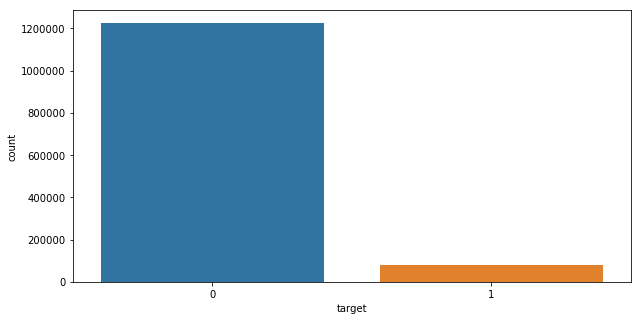

In [43]:
## barplot 
plt.figure(figsize=(10,5))
ax = sns.countplot(x="target", data=data)

In [ ]:
## pieplot
## Data is highly imbalanced with only 6.19% of insincere questions

In [44]:
## Wordcloud to see frequently occuring words in the data
STOPWORDS = stopwords.words('english')


In [100]:
results = []
def extract_ngrams(row_no, ngram):
    text = toxic_train['question_text'][row_no]
    tokens = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngram_tokens = zip(*[tokens[i:] for i in range(ngram)])
    return [" ".join(ngram_token) for ngram_token in ngram_tokens]

def collect_results(result):
    results.append(result)

In [62]:
def ngram_frequency(word_list):
    freq_dict = defaultdict(int)
    for each_list in word_list:
        for word in each_list:
            if word not in freq_dict:
                freq_dict[word] = 1
            else:
                freq_dict[word] += 1
    freq_df = pd.DataFrame(freq_dict.items())
    freq_df.columns = ["word", "wordcount"]
    freq_df.sort_values(by=['wordcount'], inplace=True, ascending=False)
    return freq_df

In [94]:
## Bar plot for top n-grams in sincere vs in-sincere questions
def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="blue")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="blue")
    
    ax[0].set_xlabel('Word count', size=14, color="blue")
    ax[0].set_ylabel('Words', size=14, color="blue")
    ax[0].set_title('Top words in sincere questions', size=18, color="blue")
    
    ax[1].set_xlabel('Word count', size=14, color="blue")
    ax[1].set_ylabel('Words', size=14, color="blue")
    ax[1].set_title('Top words in insincere questions', size=18, color="blue")

    fig.subplots_adjust(wspace=space)
    
    plt.show()

In [98]:
## extract unigrams for non_toxic dataframe
for i in range(len(non_toxic_train)):
    result = pool.apply_async(extract_ngrams, (i, 1), callback=collect_results)
pool.close()
pool.join()

## build the dataframe with unigram in non_toxic dataframe and their frequency
sincere_freq_df = ngram_frequency(results)

In [99]:
sincere_freq_df

,word,wordcount
499,best,56925
103,get,55121
8,would,53596
10,people,35724
549,like,35306
...,...,...
214191,facility/hospital,1
214192,f0,1
214193,"""healthcare""",1
214194,"care"",",1


In [102]:
## extract unigrams for toxic dataframe
for i in range(len(toxic_train)):
    result = pool.apply_async(extract_ngrams, (i, 1), callback=collect_results)
pool.close()
pool.join()

## build a new dataframe with unigrams in toxic dataframe and their frequency
insincere_freq_df = ngram_frequency(results)

In [103]:
insincere_freq_df

,word,wordcount
148,people,708
381,like,364
129,trump,322
86,would,258
695,women,255
...,...,...
7122,"-""most",1
7124,"covered""",1
7125,insurance.,1
7126,haredi,1


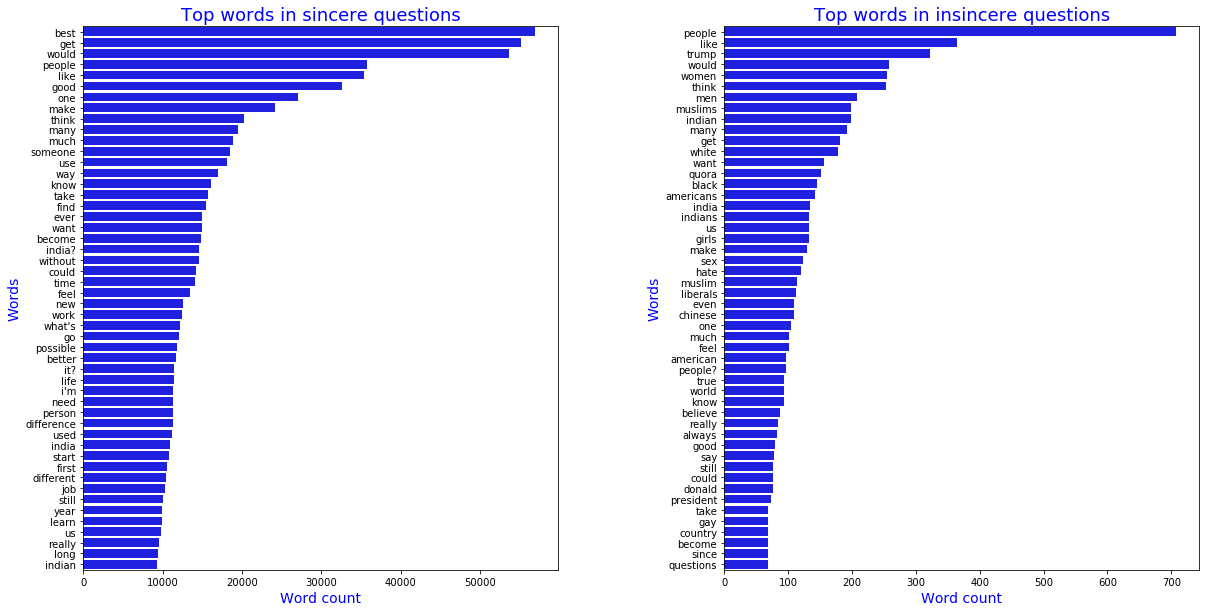

In [105]:
comparison_plot(sincere_freq_df[0:50], insincere_freq_df[0:50],'word','wordcount', .35)

In [87]:
## extract bigrams for non_toxic dataframe
for i in range(len(non_toxic_train)):
    result = pool.apply_async(extract_ngrams, (i, 2), callback=collect_results)
pool.close()
pool.join()

## build the dataframe with unigram in non_toxic dataframe and their frequency
sincere_bigram_df = ngram_frequency(results)

In [88]:
sincere_bigram_df

,word,wordcount
478,best way,6534
1419,would happen,3127
2169,year old,2785
292,get rid,2171
7333,feel like,2130
...,...,...
1530740,"boss, boss'",1
1530741,boss' boss,1
1530742,boss hr?,1
1530743,printer become,1


In [91]:
## extract bigrams for non_toxic dataframe
for i in range(len(toxic_train)):
    result = pool.apply_async(extract_ngrams, (i, 2), callback=collect_results)
pool.close()
pool.join()

## build the dataframe with unigram in non_toxic dataframe and their frequency
insincere_bigram_df = ngram_frequency(results)

In [92]:
insincere_bigram_df

,word,wordcount
851,donald trump,63
2034,white people,45
2263,black people,39
2910,year old,27
3108,people think,26
...,...,...
13402,new hampshire,1
13401,vote new,1
13400,brought vote,1
13399,voters brought,1


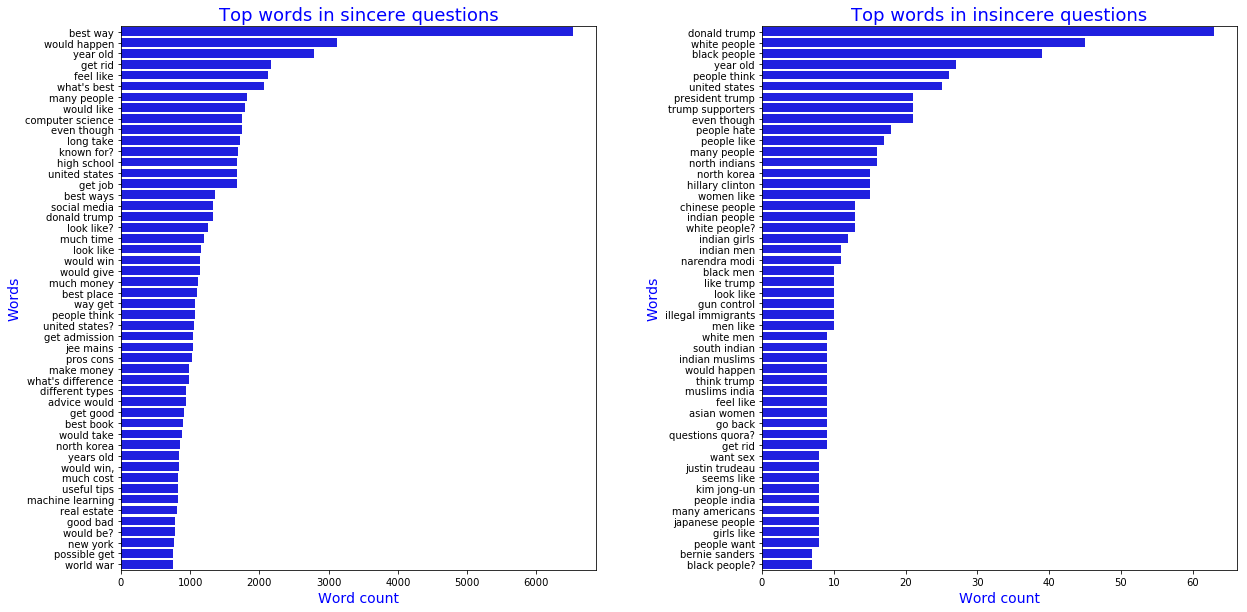

In [95]:
comparison_plot(sincere_bigram_df[0:50], insincere_bigram_df[0:50],'word','wordcount', .35)